In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
train = pd.read_csv("data/train.csv", parse_dates=["first_active_month"])
test = pd.read_csv("data/test.csv", parse_dates=["first_active_month"])
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [15]:
historical_transactions = pd.read_csv("data/historical_transactions.csv")
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [16]:
# Calculate number of historical transactions by card_id
purchases = historical_transactions.groupby("card_id")
purchases = purchases["purchase_amount"].size().reset_index()
purchases.columns = ["card_id", "num_hist_transactions"]

# Merge with training and test set
train = train.merge(purchases, on="card_id", how="left")
test = test.merge(purchases, on="card_id", how="left")

train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133


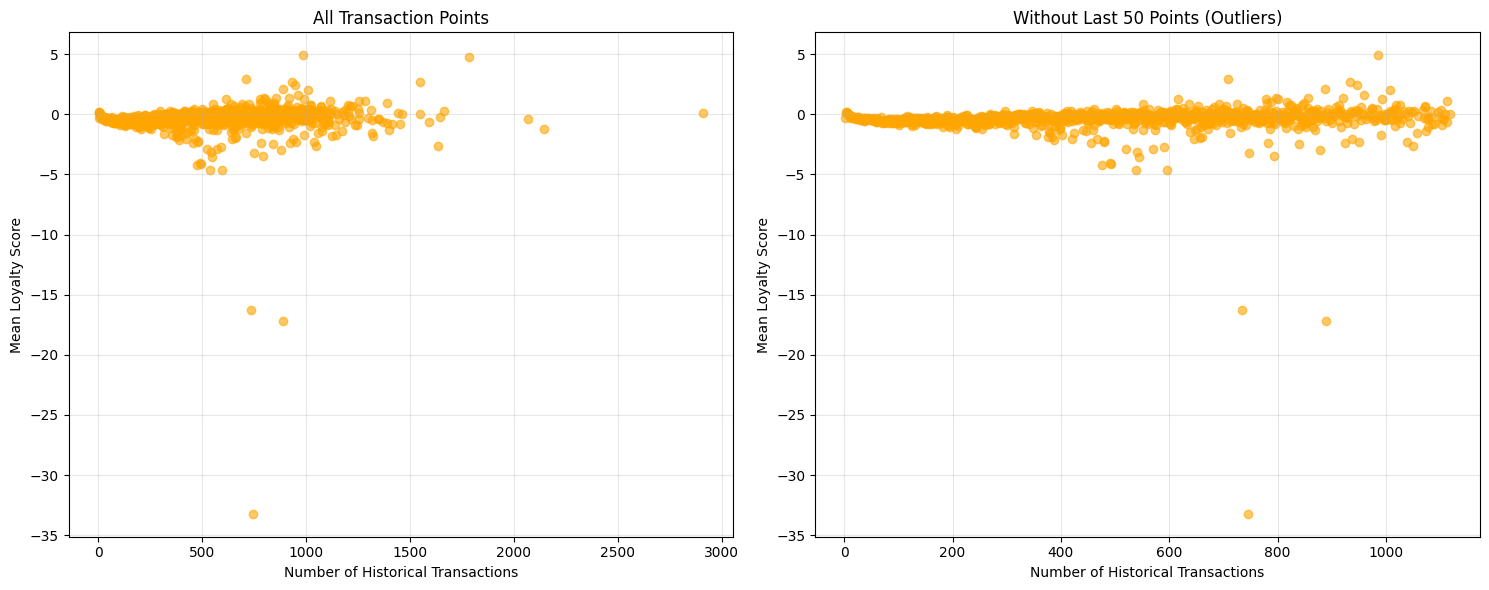

In [18]:
# Calculate mean loyalty score by number of transactions
cnt_srs = train.groupby("num_hist_transactions")["target"].mean()
cnt_srs = cnt_srs.sort_index()

# Create two subplots
plt.figure(figsize=(15, 6))

# Plot 1: All points
plt.subplot(1, 2, 1)
plt.scatter(cnt_srs.index[::-1], cnt_srs.values[::-1], color='orange', alpha=0.6)
plt.title('All Transaction Points')
plt.xlabel('Number of Historical Transactions')
plt.ylabel('Mean Loyalty Score')
plt.grid(True, alpha=0.3)

# Plot 2: Without last 50 points
plt.subplot(1, 2, 2)
cnt_srs_filtered = cnt_srs[:-50]  # TODO: OUTLIERS
plt.scatter(cnt_srs_filtered.index[::-1], cnt_srs_filtered.values[::-1], color='orange', alpha=0.6)
plt.title('Without Last 50 Points (Outliers)')
plt.xlabel('Number of Historical Transactions')
plt.ylabel('Mean Loyalty Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()

/tmp/ipykernel_32972/4228394743.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt_srs_binned = train.groupby("binned_num_hist_transactions")["target"].mean()



Mean loyalty score by binned transaction counts:
binned_num_hist_transactions
(0, 10]         0.018791
(10, 20]       -0.239937
(20, 30]       -0.322822
(30, 40]       -0.396614
(40, 50]       -0.383919
(50, 75]       -0.487289
(75, 100]      -0.545137
(100, 150]     -0.500725
(150, 200]     -0.498041
(200, 500]     -0.435845
(500, 10000]   -0.339671
Name: target, dtype: float64


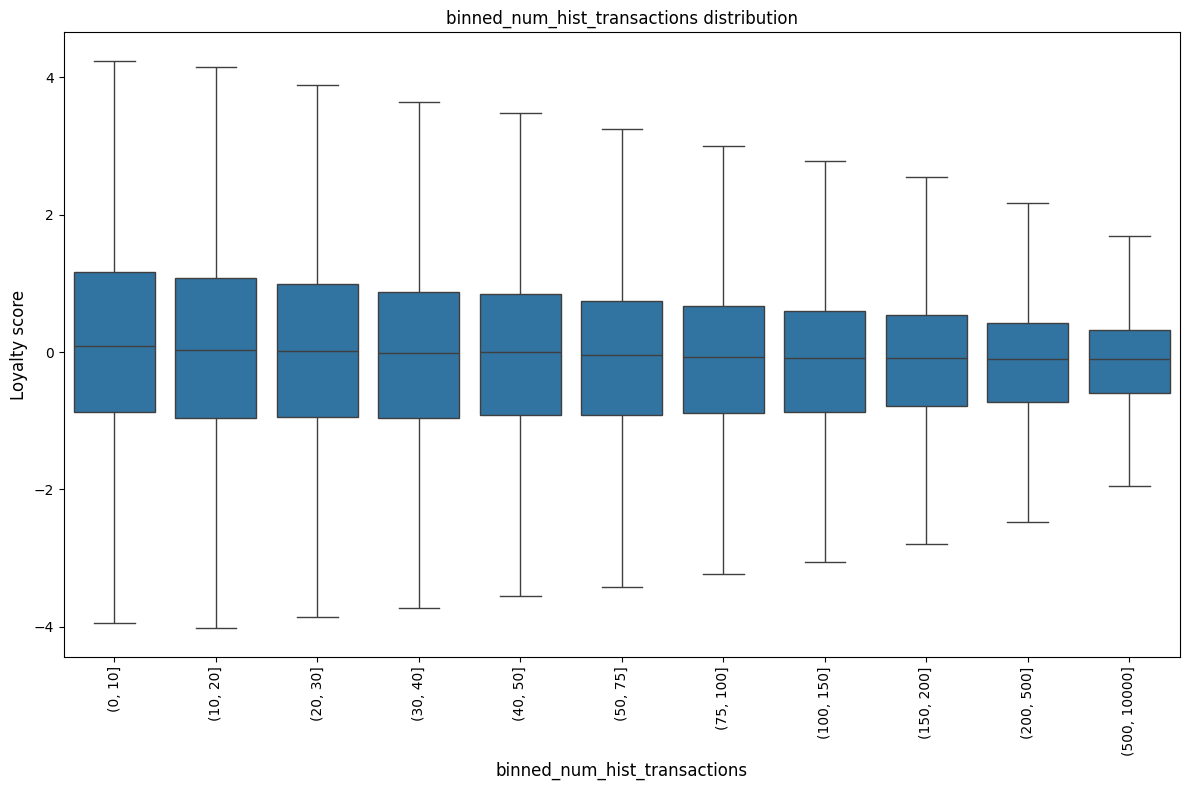

In [20]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]
train['binned_num_hist_transactions'] = pd.cut(train['num_hist_transactions'], bins)

# Calculate mean loyalty score by binned transactions
cnt_srs_binned = train.groupby("binned_num_hist_transactions")["target"].mean()
print("\nMean loyalty score by binned transaction counts:")
print(cnt_srs_binned)

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_hist_transactions", y="target", data=train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("binned_num_hist_transactions distribution")
plt.tight_layout()